In [12]:
!pip install seaborn

In [13]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf

In [14]:
# to share the GPU resources for multiple sessions
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True # dynamically grow the memory used on the GPU
config.log_device_placement = True # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

%matplotlib inline

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GRID A100D-80C, pci bus id: 0000:02:02.0, compute capability: 8.0



2023-11-10 05:28:26.741475: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-10 05:28:26.741791: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-10 05:28:26.741895: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

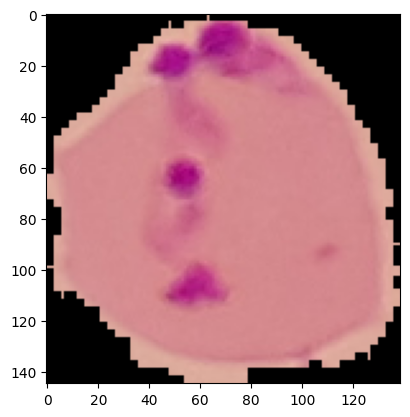

In [15]:
my_data_dir = './dataset/cell_images'
os.listdir(my_data_dir)
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

os.listdir(train_path)
len(os.listdir(train_path+'/uninfected/'))
len(os.listdir(train_path+'/parasitized/'))
os.listdir(train_path+'/parasitized')[5]

para_img= imread(train_path+
                 '/parasitized/'+
                 os.listdir(train_path+'/parasitized')[5])
plt.imshow(para_img)

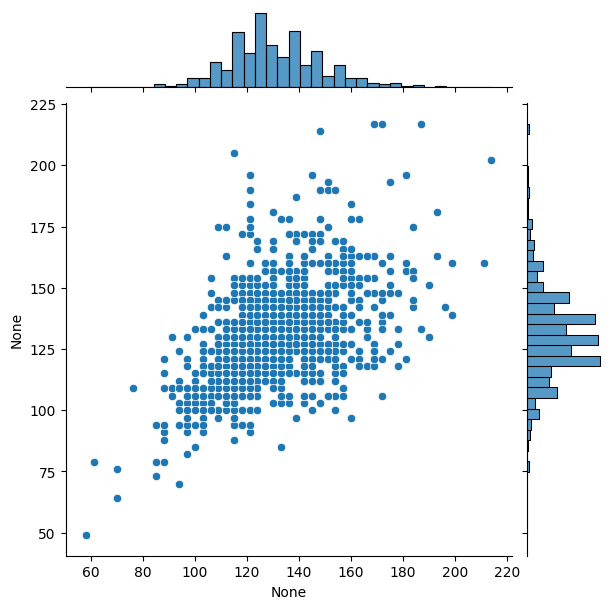

In [16]:
# Checking the image dimensions
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

sns.jointplot(x=dim1,y=dim2)
image_shape = (130,130,3)

In [17]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

image_gen.flow_from_directory(train_path)
image_gen.flow_from_directory(test_path)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [18]:
model = models.Sequential()
model.add(keras.Input(shape=(image_shape)))
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(128))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

batch_size = 16

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 29, 29, 32)        18464     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 14, 14, 32)       

In [19]:
train_image_gen = image_gen.flow_from_directory(train_path,target_size=image_shape[:2],
                              color_mode='rgb',batch_size=batch_size,class_mode='binary')
train_image_gen.batch_size
len(train_image_gen.classes)
train_image_gen.total_batches_seen
test_image_gen = image_gen.flow_from_directory(test_path,target_size=image_shape[:2],
                              color_mode='rgb',batch_size=batch_size,
                              class_mode='binary',shuffle=False)
train_image_gen.class_indices
results = model.fit(train_image_gen,epochs=8,validation_data=test_image_gen)
model.save('cell_model.h5')

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.
Epoch 1/8
1560/1560 [==============================] - 110s 69ms/step - loss: 0.6875 - accuracy: 0.5498 - val_loss: 0.6850 - val_accuracy: 0.5542
Epoch 2/8
1560/1560 [==============================] - 108s 69ms/step - loss: 0.6831 - accuracy: 0.5606 - val_loss: 0.6800 - val_accuracy: 0.5604
Epoch 3/8
1560/1560 [==============================] - 108s 69ms/step - loss: 0.6779 - accuracy: 0.5775 - val_loss: 0.6754 - val_accuracy: 0.5858
Epoch 4/8
1560/1560 [==============================] - 107s 68ms/step - loss: 0.6715 - accuracy: 0.5945 - val_loss: 0.6744 - val_accuracy: 0.5858
Epoch 5/8
1560/1560 [==============================] - 106s 68ms/step - loss: 0.5770 - accuracy: 0.6843 - val_loss: 0.2815 - val_accuracy: 0.9138
Epoch 6/8
1560/1560 [==============================] - 107s 68ms/step - loss: 0.2173 - accuracy: 0.9322 - val_loss: 0.2003 - val_accuracy: 0.9369
Epoch 7/8
1560/1560 [==================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['loss', 'accuracy']

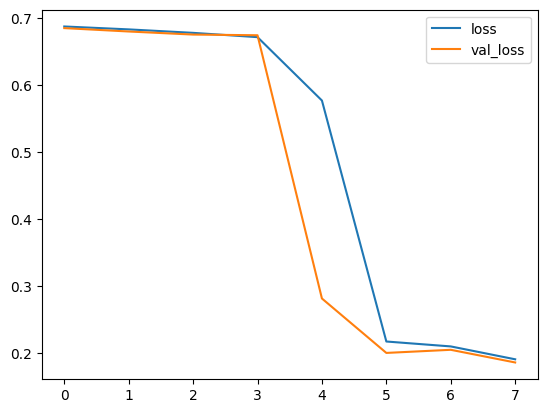

In [20]:
losses = pd.DataFrame(model.history.history)
losses[['loss','val_loss']].plot()
model.metrics_names

In [21]:
model.evaluate(test_image_gen)
pred_probabilities = model.predict(test_image_gen)
test_image_gen.classes
predictions = pred_probabilities > 0.5
print(classification_report(test_image_gen.classes,predictions))
confusion_matrix(test_image_gen.classes,predictions)

163/163 [==============================] - 10s 58ms/step
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      1300
           1       0.93      0.95      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



array([[1213,   87],
       [  62, 1238]])

In [22]:
import random as rnd

1/1 [==============================] - 0s 117ms/step


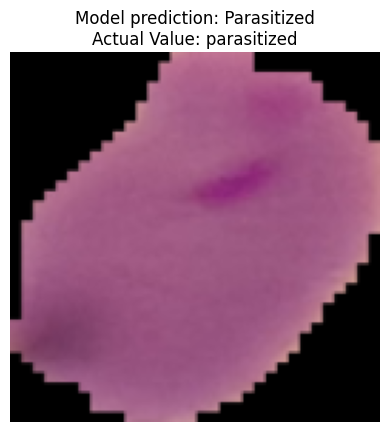

In [23]:
list_dir=["Un Infected","parasitized"]
dir_=(rnd.choice(list_dir))
p_img=imread(train_path+'/'+dir_+'/'+os.listdir(train_path+'/'+dir_)[rnd.randint(0,100)])
img  = tf.convert_to_tensor(np.asarray(p_img))
img = tf.image.resize(img,(130,130))
img=img.numpy()
pred=bool(model.predict(img.reshape(1,130,130,3))<0.5 )
plt.title("Model prediction: "+("Parasitized" if pred  else "Un Infected")
			+"\nActual Value: "+str(dir_))
plt.axis("off")
plt.imshow(img)
plt.show()